In [41]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import io
import sys
import tempfile
import tqdm
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)


Cloning into 'examples'...
remote: Enumerating objects: 23096, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 23096 (delta 17), reused 41 (delta 9), pack-reused 23038
Receiving objects: 100% (23096/23096), 42.18 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (12670/12670), done.


In [3]:

# loading the model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [4]:

#  returns skeleton of the person detected by movenet
# copied from tensorflow movenets
def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [5]:
# return the image with a skeleton drawn on the human body
# copied from tensorflow movenets
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [6]:
# finding the angles at different joints
def cal_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
#    tan theta = slope -- slope = tan inverse theta
#    difference btw to slopes to find the angle between the two lines(joints)
    angle = np.abs((np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])) * 180.0/np.pi)
    if angle >  180.0:
        angle = 360.0 - angle
        
    return angle

In [7]:
# detecte pose landmarks and corresponding angles and save them to csv
class MoveNetPreprocessor(object):
  # preprocess pose sample images for classification
  def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    # making list of poses by using the folder name
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

  def process(self, per_pose_class_limit= None, detection_threshold=0.6):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # defining paths for the pose class
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
      # making output folder if not exists
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter = ',', quoting = csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          # iterating to all images till the max pose limit
          image_names = image_names[:per_pose_class_limit]
        # image counter
        valid_image_count = 0
        # Detect pose landmarks from each image
        # tqdm make the progress bars
        for image_name in tqdm.tqdm(image_names):
          # defining the path of the image
          image_path = os.path.join(images_in_folder, image_name)
          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
            continue
          #  using detect function to make the skeleton of the person in the following image
          person = detect(image)

          # forming a dictionary of body parts with their corresponding coordinates
          body_parts = []
          body_coordinates = []
          i = 0
          for keypoints in person.keypoints:
              x_val = keypoints.coordinate.x
              y_val = keypoints.coordinate.y
              i = i+1
              pos = [x_val, y_val]
              a = str(keypoints[0])
              body_parts.append(str(a.split('.')[-1]))
              body_coordinates.append(pos)

          L1 = body_parts
          L2 = body_coordinates
          bp_coordinates = dict(zip(L1,L2))
          # bp_coordinates

          # forming an array of angles for every joint detected to add it to csv data
          body_angles = []
          parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
          for pts in parts:
              part_1 = bp_coordinates[pts[0]]
              part_2 = bp_coordinates[pts[1]]
              part_3 = bp_coordinates[pts[2]]
              body_angles.append(cal_angle(part_1, part_2, part_3))

          # print(body_angles)
          # Save landmarks if all landmarks were detected
          # saving the landmarks that have detection score greater than the set threshold
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +'. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          # Drawing the landmarks on the image that satisfy the threshold factor by using the above function
          output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)

          # converting RGB to BGR so that it can be used in opencv
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          # saving the output images having filtered landmarks
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          # [x, y, score]  for every landmark
          pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, body_angles[index], keypoint.score] for index, keypoint in enumerate(person.keypoints)], dtype=np.float32)

          # saving the coordinates with the image nape in csv file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      # creating csv path for each pose type
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

--2023-04-17 17:31:06--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.14.16, 104.18.15.16, 2606:4700::6812:f10, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.14.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29024 (28K) [binary/octet-stream]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  28.34K  --.-KB/s    in 0.002s  

2023-04-17 17:31:07 (15.1 MB/s) - ‘/tmp/image.jpeg’ saved [29024/29024]



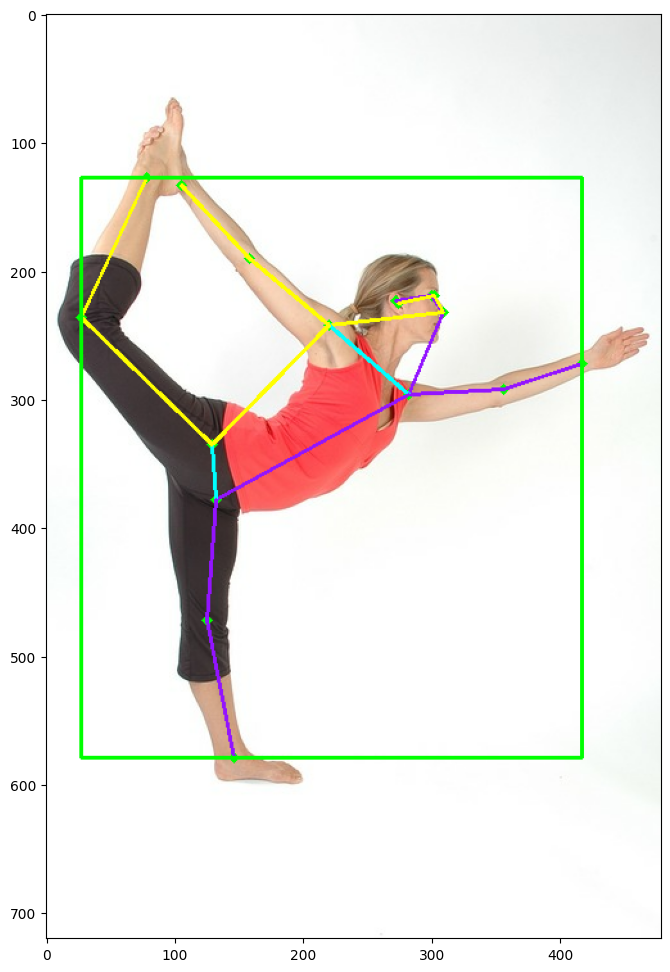

In [8]:

# printing landmarks on the image
test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg"
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  t = draw_prediction_on_image(image.numpy(), person, crop_region=None,close_figure=False, keep_input_size=True)

In [9]:

!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:

! mkdir ~/.kaggle

In [11]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"prachi124","key":"5e1791366de1f5638ab7e7778878c432"}'}

In [12]:

! cp kaggle.json ~/.kaggle/

In [13]:
! kaggle datasets download -d niharika41298/yoga-poses-dataset

 99% 285M/288M [00:03<00:00, 112MB/s]
100% 288M/288M [00:03<00:00, 83.4MB/s]


In [14]:
!unzip yoga-poses-dataset

Archive:  yoga-poses-dataset.zip
  inflating: DATASET/TEST/downdog/00000000.jpg  
  inflating: DATASET/TEST/downdog/00000001.JPG  
  inflating: DATASET/TEST/downdog/00000002.jpg  
  inflating: DATASET/TEST/downdog/00000003.jpg  
  inflating: DATASET/TEST/downdog/00000004.jpg  
  inflating: DATASET/TEST/downdog/00000005.jpg  
  inflating: DATASET/TEST/downdog/00000006.jpg  
  inflating: DATASET/TEST/downdog/00000007.jpg  
  inflating: DATASET/TEST/downdog/00000008.jpg  
  inflating: DATASET/TEST/downdog/00000009.jpg  
  inflating: DATASET/TEST/downdog/00000010.png  
  inflating: DATASET/TEST/downdog/00000011.jpg  
  inflating: DATASET/TEST/downdog/00000012.jpg  
  inflating: DATASET/TEST/downdog/00000013.jpg  
  inflating: DATASET/TEST/downdog/00000014.jpg  
  inflating: DATASET/TEST/downdog/00000016.jpg  
  inflating: DATASET/TEST/downdog/00000017.png  
  inflating: DATASET/TEST/downdog/00000018.jpg  
  inflating: DATASET/TEST/downdog/00000019.jpg  
  inflating: DATASET/TEST/downdog/00

In [15]:
os.listdir('./DATASET')

['TRAIN', 'TEST']

In [16]:
import shutil

import os
dataset_dir = './DATASET/TRAIN'
detection_classes = []
for entry in os.scandir(dataset_dir):
  l = entry.path
  detection_classes.append(l.split('/')[-1])

print(detection_classes)

['goddess', 'tree', 'downdog', 'warrior2', 'plank']


In [17]:

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './DATASET/TRAIN'
test_dir = './DATASET/TEST'

In [18]:

train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, zoom_range = 0.2)
train_dataset = train_datagen.flow_from_directory(train_dir, classes = detection_classes, shuffle=True, batch_size= 12, target_size=(120, 120))

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, zoom_range = 0.2)
test_dataset = test_datagen.flow_from_directory(test_dir, classes = detection_classes, shuffle=True, batch_size= 12, target_size=(120, 120))

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [19]:
images_in_train_folder = './DATASET/TRAIN'
images_out_train_folder = './yoga_train_detect'
csv_out_train_path = './yoga_train_csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csv_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)
     

Preprocessing downdog
  2%|▏         | 5/223 [00:22<16:27,  4.53s/it]<ipython-input-7-27b7509d1f7a>:123: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|██████████| 223/223 [12:25<00:00,  3.34s/it]
Preprocessing goddess
 69%|██████▉   | 125/180 [06:49<03:01,  3.30s/it]/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [09:58<00:00,  3.32s/it]
P

Skipped ./DATASET/TRAIN/downdog/00000128.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000129.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000130.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000131.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000132.png. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000134.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000135.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000137.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000139.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000140.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000142.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000143.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/down

In [20]:

#  preprocessing test dataset

images_in_test_folder = './DATASET/TEST/' 
images_out_test_folder = './yoga_test_detect'
csv_out_test_path = './yoga_test_csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csv_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
  2%|▏         | 2/97 [00:06<05:14,  3.31s/it]<ipython-input-7-27b7509d1f7a>:123: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|██████████| 97/97 [05:09<00:00,  3.19s/it]
Preprocessing goddess
100%|██████████| 80/80 [04:21<00:00,  3.26s/it]
Preprocessing plank
100%|██████████| 115/115 [06:15<00:00,  3.26s/it]
Preprocessing tree
 86%|████████▌ | 59/69 [03:18<00:33,  3.39s/it]/usr/local/lib/python3.9/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: 

Skipped ./DATASET/TEST/downdog/00000000.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000001.JPG. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000003.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000004.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000008.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000010.png. Image isn't in RGB format.
Skipped ./DATASET/TEST/downdog/00000011.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000012.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000013.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000017.png. Image isn't in RGB format.
Skipped ./DATASET/TEST/downdog/00000018.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000019.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000020.jpg. No pose was

In [21]:
dataframe = pd.read_csv(csv_out_train_path)

train = dataframe.copy()

# Drop the file_name columns as you don't need it during training.
train.drop(columns=['file_name'], inplace=True)
train.drop(columns=['class_name'], inplace=True)
train.to_csv("final_train_movenet.csv")
train

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,60,61,62,63,64,65,66,67,68,class_no
0,588.0,563.0,0.0,0.776305,571.0,568.0,0.0,0.644391,571.0,566.0,...,0.919854,903.0,592.0,0.0,0.885403,890.0,586.0,0.0,0.854555,0
1,443.0,473.0,0.0,0.846087,423.0,483.0,0.0,0.722005,423.0,481.0,...,0.866245,889.0,527.0,0.0,0.732527,886.0,522.0,0.0,0.734628,0
2,460.0,754.0,0.0,0.743380,446.0,758.0,0.0,0.623463,447.0,756.0,...,0.779033,761.0,773.0,0.0,0.861440,736.0,754.0,0.0,0.902257,0
3,460.0,754.0,0.0,0.743380,446.0,758.0,0.0,0.623463,447.0,756.0,...,0.779033,761.0,773.0,0.0,0.861440,736.0,754.0,0.0,0.902257,0
4,380.0,304.0,0.0,0.788868,369.0,309.0,0.0,0.612512,369.0,306.0,...,0.831590,630.0,351.0,0.0,0.654901,613.0,334.0,0.0,0.902829,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,366.0,143.0,0.0,0.812638,373.0,136.0,0.0,0.809895,363.0,136.0,...,0.819663,518.0,379.0,0.0,0.948987,284.0,382.0,0.0,0.847253,4
389,669.0,93.0,0.0,0.713464,685.0,79.0,0.0,0.892298,670.0,79.0,...,0.903380,936.0,616.0,0.0,0.813104,551.0,620.0,0.0,0.948280,4
390,283.0,163.0,0.0,0.636360,285.0,158.0,0.0,0.873758,287.0,158.0,...,0.724444,416.0,327.0,0.0,0.930972,278.0,338.0,0.0,0.879604,4
391,208.0,380.0,0.0,0.718539,214.0,375.0,0.0,0.751216,213.0,374.0,...,0.811829,314.0,575.0,0.0,0.885095,147.0,551.0,0.0,0.816177,4


In [22]:
dataframe = pd.read_csv(csv_out_test_path)

test = dataframe.copy()

# Drop the file_name columns as you don't need it during training.
test.drop(columns=['file_name'], inplace=True)
test.drop(columns=['class_name'], inplace=True)
test.to_csv("final_test_movenet.csv")
test

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,60,61,62,63,64,65,66,67,68,class_no
0,1350.0,1175.0,0.0,0.734030,1407.0,1184.0,0.0,0.786012,1404.0,1185.0,...,0.838162,240.0,1317.0,0.0,0.752556,210.0,1344.0,0.0,0.838340,0
1,378.0,669.0,0.0,0.719442,353.0,676.0,0.0,0.707194,353.0,673.0,...,0.779183,872.0,797.0,0.0,0.886646,842.0,766.0,0.0,0.742099,0
2,343.0,460.0,0.0,0.837512,325.0,451.0,0.0,0.607678,324.0,450.0,...,0.861905,817.0,525.0,0.0,0.829100,787.0,493.0,0.0,0.769914,0
3,264.0,254.0,0.0,0.689544,254.0,257.0,0.0,0.649948,253.0,256.0,...,0.776012,504.0,290.0,0.0,0.898325,493.0,275.0,0.0,0.853633,0
4,1880.0,1865.0,0.0,0.787886,1808.0,1881.0,0.0,0.787882,1798.0,1868.0,...,0.735683,3644.0,2086.0,0.0,0.787845,3521.0,2061.0,0.0,0.724669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,549.0,86.0,0.0,0.815422,563.0,73.0,0.0,0.887607,556.0,71.0,...,0.820349,882.0,612.0,0.0,0.915147,377.0,613.0,0.0,0.919081,4
247,93.0,107.0,0.0,0.692518,97.0,104.0,0.0,0.853926,95.0,103.0,...,0.906818,180.0,226.0,0.0,0.928587,55.0,223.0,0.0,0.952375,4
248,529.0,194.0,0.0,0.852125,541.0,184.0,0.0,0.916908,536.0,183.0,...,0.891254,805.0,588.0,0.0,0.884487,407.0,586.0,0.0,0.837962,4
249,273.0,160.0,0.0,0.756993,278.0,153.0,0.0,0.872856,275.0,153.0,...,0.932370,420.0,369.0,0.0,0.729069,193.0,371.0,0.0,0.852331,4


In [23]:
print(train['class_no'].unique())
print(test['class_no'].unique())

[0 1 2 3 4]
[0 1 2 3 4]


In [24]:
x_train=train.iloc[:,:68]
x_train

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,59,60,61,62,63,64,65,66,67,68
0,588.0,563.0,0.0,0.776305,571.0,568.0,0.0,0.644391,571.0,566.0,...,176.31720,0.919854,903.0,592.0,0.0,0.885403,890.0,586.0,0.0,0.854555
1,443.0,473.0,0.0,0.846087,423.0,483.0,0.0,0.722005,423.0,481.0,...,170.35684,0.866245,889.0,527.0,0.0,0.732527,886.0,522.0,0.0,0.734628
2,460.0,754.0,0.0,0.743380,446.0,758.0,0.0,0.623463,447.0,756.0,...,136.75612,0.779033,761.0,773.0,0.0,0.861440,736.0,754.0,0.0,0.902257
3,460.0,754.0,0.0,0.743380,446.0,758.0,0.0,0.623463,447.0,756.0,...,136.75612,0.779033,761.0,773.0,0.0,0.861440,736.0,754.0,0.0,0.902257
4,380.0,304.0,0.0,0.788868,369.0,309.0,0.0,0.612512,369.0,306.0,...,177.21686,0.831590,630.0,351.0,0.0,0.654901,613.0,334.0,0.0,0.902829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,366.0,143.0,0.0,0.812638,373.0,136.0,0.0,0.809895,363.0,136.0,...,116.89669,0.819663,518.0,379.0,0.0,0.948987,284.0,382.0,0.0,0.847253
389,669.0,93.0,0.0,0.713464,685.0,79.0,0.0,0.892298,670.0,79.0,...,131.65976,0.903380,936.0,616.0,0.0,0.813104,551.0,620.0,0.0,0.948280
390,283.0,163.0,0.0,0.636360,285.0,158.0,0.0,0.873758,287.0,158.0,...,101.18982,0.724444,416.0,327.0,0.0,0.930972,278.0,338.0,0.0,0.879604
391,208.0,380.0,0.0,0.718539,214.0,375.0,0.0,0.751216,213.0,374.0,...,111.87717,0.811829,314.0,575.0,0.0,0.885095,147.0,551.0,0.0,0.816177


In [25]:
y_train=train.iloc[:,68]
y_train

0      0
1      0
2      0
3      0
4      0
      ..
388    4
389    4
390    4
391    4
392    4
Name: class_no, Length: 393, dtype: int64

In [26]:
x_test=test.iloc[:,:68]
x_test

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,RIGHT_EYE_x,RIGHT_EYE_y,RIGHT_EYE_score,LEFT_EAR_x,...,59,60,61,62,63,64,65,66,67,68
0,1350.0,1175.0,0.0,0.734030,1407.0,1184.0,0.0,0.786012,1404.0,1185.0,...,175.011750,0.838162,240.0,1317.0,0.0,0.752556,210.0,1344.0,0.0,0.838340
1,378.0,669.0,0.0,0.719442,353.0,676.0,0.0,0.707194,353.0,673.0,...,172.878080,0.779183,872.0,797.0,0.0,0.886646,842.0,766.0,0.0,0.742099
2,343.0,460.0,0.0,0.837512,325.0,451.0,0.0,0.607678,324.0,450.0,...,176.965410,0.861905,817.0,525.0,0.0,0.829100,787.0,493.0,0.0,0.769914
3,264.0,254.0,0.0,0.689544,254.0,257.0,0.0,0.649948,253.0,256.0,...,179.533110,0.776012,504.0,290.0,0.0,0.898325,493.0,275.0,0.0,0.853633
4,1880.0,1865.0,0.0,0.787886,1808.0,1881.0,0.0,0.787882,1798.0,1868.0,...,174.771940,0.735683,3644.0,2086.0,0.0,0.787845,3521.0,2061.0,0.0,0.724669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,549.0,86.0,0.0,0.815422,563.0,73.0,0.0,0.887607,556.0,71.0,...,112.444090,0.820349,882.0,612.0,0.0,0.915147,377.0,613.0,0.0,0.919081
247,93.0,107.0,0.0,0.692518,97.0,104.0,0.0,0.853926,95.0,103.0,...,100.123375,0.906818,180.0,226.0,0.0,0.928587,55.0,223.0,0.0,0.952375
248,529.0,194.0,0.0,0.852125,541.0,184.0,0.0,0.916908,536.0,183.0,...,115.213370,0.891254,805.0,588.0,0.0,0.884487,407.0,586.0,0.0,0.837962
249,273.0,160.0,0.0,0.756993,278.0,153.0,0.0,0.872856,275.0,153.0,...,114.420944,0.932370,420.0,369.0,0.0,0.729069,193.0,371.0,0.0,0.852331


In [27]:
y_test=test.iloc[:,68]
y_test

0      0
1      0
2      0
3      0
4      0
      ..
246    4
247    4
248    4
249    4
250    4
Name: class_no, Length: 251, dtype: int64

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

In [29]:
x_train.shape

(393, 68)

In [30]:
y_train.shape

(393,)

In [31]:
modelDecisionTreeRegressor = DecisionTreeRegressor() 
modelDecisionTreeRegressor.fit(x_train,y_train)

DecisionTreeRegressor()

In [32]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth=10) # you can use GINI index also here as a critirion 
clf = clf.fit(x_train,y_train)
y_pred1 = clf.predict(x_test)
y_pred1

array([0, 0, 0, 0, 1, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4])

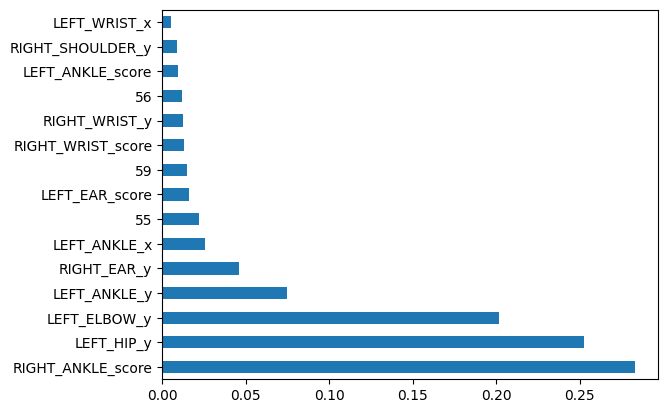

In [33]:
feat_importances = pd.Series(clf.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [34]:
y_pred2 = modelDecisionTreeRegressor.predict(x_test)
y_pred2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 3., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 3., 1., 1., 1., 1., 1., 1., 4., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1., 3.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       3., 2., 2., 2., 2., 3., 4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 2., 4.,
       4., 4., 4., 4., 4., 2., 4., 4., 2., 4., 4., 4., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 2., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
modelLogistic = LogisticRegression()
modelLogistic.fit(x_train,y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [36]:
y_pred3= modelLogistic.predict(x_test)

In [37]:
print("Accuracy of DcisionTreeRegressor:",metrics.accuracy_score(y_test, y_pred2))
print("Recall_score of DcisionTreeRegressor:",metrics.recall_score(y_test, y_pred2,average='macro'))
print("Precision_score of DcisionTreeRegressor:",metrics.precision_score(y_test, y_pred2,average='macro'))

Accuracy of DcisionTreeRegressor: 0.9203187250996016
Recall_score of DcisionTreeRegressor: 0.9240216977921897
Precision_score of DcisionTreeRegressor: 0.9021108308813226


In [38]:
print("Accuracy of DecisionTreeClassifier:",metrics.accuracy_score(y_test, y_pred1))
print("Recall_score of DecisionTreeClassifier:",metrics.recall_score(y_test, y_pred1,average='macro'))
print("Precision_score of DecisionTreeClassifier:",metrics.precision_score(y_test, y_pred1,average='macro'))

Accuracy of DecisionTreeClassifier: 0.9402390438247012
Recall_score of DecisionTreeClassifier: 0.9301697391861327
Precision_score of DecisionTreeClassifier: 0.9210223651203051


In [39]:
print("Accuracy of LogisticRegression:",metrics.accuracy_score(y_test, y_pred3))
print("Recall_score of LogisticRegression:",metrics.recall_score(y_test, y_pred3,average='macro'))
print("Precision_score of LogisticRegression:",metrics.precision_score(y_test, y_pred3,average='macro'))

Accuracy of LogisticRegression: 0.900398406374502
Recall_score of LogisticRegression: 0.9266805447133315
Precision_score of LogisticRegression: 0.8830064811553016


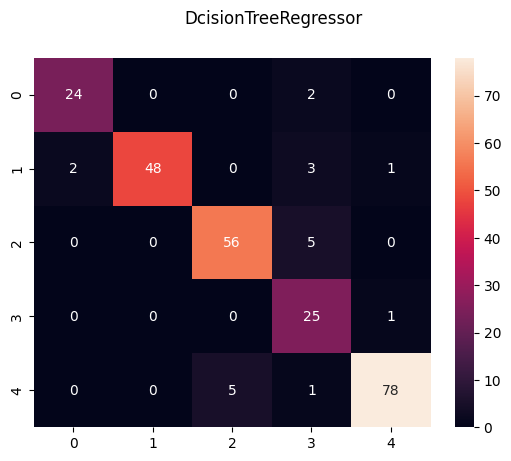

In [42]:
# DcisionTreeRegressor
cm=confusion_matrix(y_test,y_pred2)
sns.heatmap(cm,annot=True)
plt.suptitle('DcisionTreeRegressor')
plt.show()

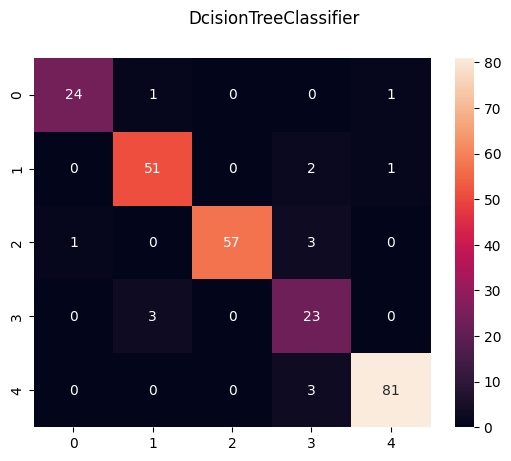

In [43]:
# DcisionTreeClassifier
cm=confusion_matrix(y_test,y_pred1)
sns.heatmap(cm,annot=True)
plt.suptitle('DcisionTreeClassifier')
plt.show()

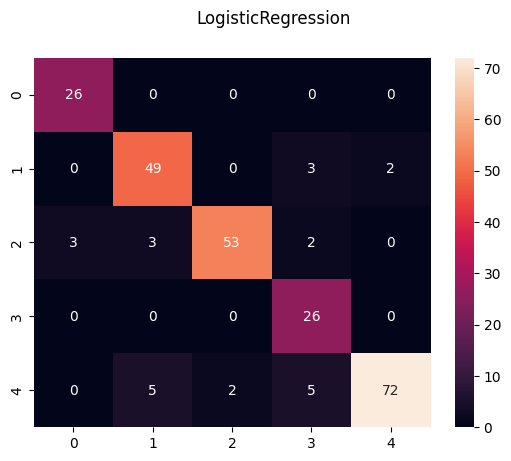

In [44]:
# LogisticRegression
cm=confusion_matrix(y_test,y_pred3)
sns.heatmap(cm,annot=True)
plt.suptitle('LogisticRegression')
plt.show()